## Analysis at a document level

1. Cosine simililarity
2. Colocations / Summerization
3. Lexical Plot

In [11]:
import nltk
from nltk import FreqDist
from nltk.collocations import *
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from textblob import TextBlob
%matplotlib inline

In [2]:
path = "C:/Users/Sen/Downloads/CUS 635 (Web data mining)/Project/Data/Combined/"
prefix = os.listdir(path)
print(prefix)

['Week1_Q1.txt', 'Week1_Q2.txt', 'Week1_Q3.txt', 'Week1_Q4.txt', 'Week2_Q1.txt', 'Week2_Q2.txt', 'Week2_Q3.txt']


In [6]:
def remove_utf(text):
    return re.sub(r'[^\x00-\x7f]',r' ',text)

#Normalization
def remove_punctuation(corpus):
    punctuations = ".,\"-\\/#!?$%\^&\*;:{}=\-_'~()"    
    filtered_corpus = [token for token in corpus if (not token in punctuations)]
    return filtered_corpus

def apply_stopwording(corpus, min_len):
    filtered_corpus = [token for token in corpus if (not token in stopwords.words('english') and len(token)>min_len)]
    return filtered_corpus

def removeAbb(x):
    lst = {'Dx':'diagnosed' ,
           'Rx':'prescription',
           'OTC':'Over The Counter',
           'DFL':'Drug Fact Label',
           'AUT':'Application Under Test'}
    for i in x:
        if i in lst:
            i = lst[i]
    return x

def apply_lemmatization(corpus):
    lemmatizer = nltk.WordNetLemmatizer()
    normalized_corpus = [lemmatizer.lemmatize(token) for token in corpus]
    return normalized_corpus

def apply_stemming(text):
    stemmer = nltk.PorterStemmer()
    normalized_text = [stemmer.stem(token) for token in text]
    return normalized_text

In [5]:
#Read the dataset
dataset={} #nltk text from tokens
dataset_raw = {} 
allFeatures=set()
tot_articles = 0
articles_count={}
raw_corpus = {} #used in sumerization
dataset2= set()
dataset3=[]
N={} # Number of articles in each corpus

for i,_ in enumerate(prefix):
    fileName = path + prefix[i]
    f=open(fileName,'r',encoding="utf8")
    text = ''
    text_raw = '' 
    
    lines = f.readlines()
    #print(_,'OK') #load test
    tot_articles+=len(lines)
    articles_count[str(_)] = len(lines)
    dataset_raw[str(_)] = list(map(lambda line: line.lower(), lines))

    for line in lines:
        dataset2.add(line.lower())
        dataset3.append(remove_utf(line.lower()))
        text+=line.replace('\n',' ').lower()
        text_raw = line.lower()
    f.close
    N[str(_)]=len(lines)
    
    tokens = nltk.word_tokenize(text)
    dataset[str(_)] = nltk.Text(tokens)
    raw_corpus[_] = text

## 1. Cosine similarity

In [82]:
tfidf_vectorizer = TfidfVectorizer(min_df=1)
tfidf_matrix = tfidf_vectorizer.fit_transform(raw_corpus.values())
#print(tfidf_matrix.shape)

simdf = pd.DataFrame()
for i in range(7):
    simdf['Doc'+str(i+1)] = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix)[0]
simdf = simdf.round(3)

print("Cosine similarity matrix:")
print(simdf)

Cosine similarity matrix:
    Doc1   Doc2   Doc3   Doc4   Doc5   Doc6   Doc7
0  1.000  0.844  0.765  0.793  0.746  0.846  0.692
1  0.844  1.000  0.752  0.774  0.776  0.858  0.666
2  0.765  0.752  1.000  0.707  0.668  0.733  0.567
3  0.793  0.774  0.707  1.000  0.697  0.773  0.569
4  0.746  0.776  0.668  0.697  1.000  0.787  0.613
5  0.846  0.858  0.733  0.773  0.787  1.000  0.681
6  0.692  0.666  0.567  0.569  0.613  0.681  1.000


The cosine similarity of documents indicates that the conversation that took place in Week1_Q1, Week1Q_2 and Week2_Q2 was highly similar, whilst the conversation in Week2_Q3 was somewhat distinguished from the rest. 

## 2. Summerization

In [83]:
#these funcions use the raw_corpus

def getCollocations(text, min_freq):
    bigrams = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(text)
    finder.apply_freq_filter(min_freq)
    collocations = finder.nbest(bigrams.pmi, 20)
    return collocations

def getSummary(article, min_freq):
    sentences = sent_tokenize(article)
    #tokens = [word_tokenize(sentence.lower()) for sentence in sentences]
    tokens = nltk.word_tokenize(article.lower())
    doc = nltk.Text(tokens)
    doc_clean = nltk.Text(apply_lemmatization(removeAbb(apply_stopwording(remove_punctuation(doc), 3))))
    collocations = getCollocations(doc_clean,min_freq)
    #print('Collocations: ', collocations)
    #print()
    
    summary = []
    for c in collocations:
        for sentence in sentences:
            term1 = c[0]
            term2 = c[1]
            term = c[0]+' '+c[1]
            if (term in sentence):
                #Found the sentence. Add only if not already in the summary
                if (sentence not in summary):
                    summary.append(sentence)
                    
    return collocations, summary

In [84]:
for i in raw_corpus:
    print()
    print('Summary of ',i)
    print()
    
    if i in ['Week1_Q2.txt']:
        min_count = 5
    elif i in ['Week2_Q3.txt']:
        min_count = 4
    elif i in ['Week2_Q1.txt']:
        min_count = 5
    else:
        min_count = 4
        
    collocation, summary = getSummary(raw_corpus[i], min_count)
    print ('Collocations: ',collocation)
    print()
    print ("No. of sentences: "+str(len(summary)))
    index = 1
    for sentence in summary:
        print ("%s - %s" % (index,sentence))
        index+=1  


Summary of  Week1_Q1.txt

Collocations:  [('alpha', 'blocker'), ('actual', 'study')]

No. of sentences: 5
1 - i agree that the symptoms may partially overlap, but even md provider will likely give alpha blocker to those pts as they do not have a full uds examination to review.
2 - i guess the issue is not the underlying comorbidity but whether the individual is taking medications for certain conditions that might interact with the alpha blocker.
3 - re brian stark: virtually all alpha blockers including tamsulosin have been studied with mostly all antihypertensive classes and the aes are not higher in those pts on antihypertensives.
4 - none of the currently mentioned conditions are an absolute contraindication to giving tamsulosin, and alpha blockers have been given regularly to patients with all of these co-morbidities.
5 - i will speak to that: alpha blockers for luts/bph are prescribed by pcp and uro and both groups prescribe probably equally common i would say the guidelines prov

Collocations:  [('tamsulosin', 'hydrochloride'), ('prostatic', 'hyperplasia'), ('benign', 'prostatic'), ('enlarged', 'prostate'), ('prostate', 'urinary'), ('symptom', 'reliever'), ('urinary', 'symptom')]

No. of sentences: 24
1 - the tamsulosin hydrochloride label uses the full name of the condition that we are discussing as "benign prostatic hyperplasia (bph)".
2 - actually the condition is no longer correctly referred toes bph but rather benign prostatic obstruction of bpo how about lower urinary symptom reliever bpo is not the tamsulosin hydrochloride indication: tamsulosin hydrochloride capsules are indicated for the treatment of the signs and symptoms of benign prostatic hyperplasia (bph).
3 - tamsulosin hydrochloride capsules are not indicated for the treatment of hypertension."
4 - a discussion point for the group might be to focus on how the indication phrase can be consistent with tamsulosin hydrochloride and support otc limitations of use, if that's possible.
5 - bph is not r

## 3. Lexical plot

Week1_Q1.txt


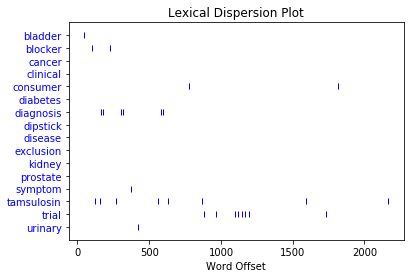

Week1_Q2.txt


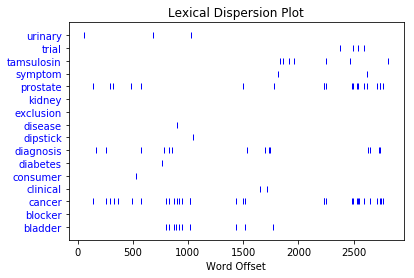

Week1_Q3.txt


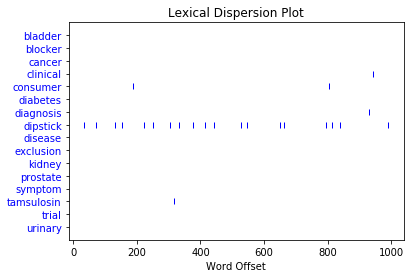

Week1_Q4.txt


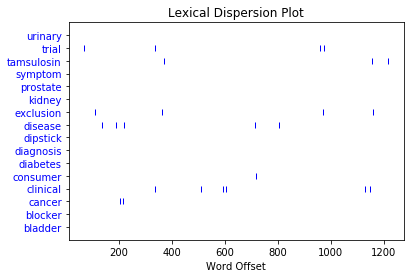

Week2_Q1.txt


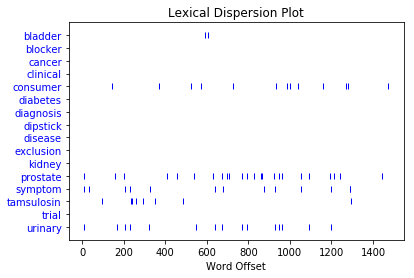

Week2_Q2.txt


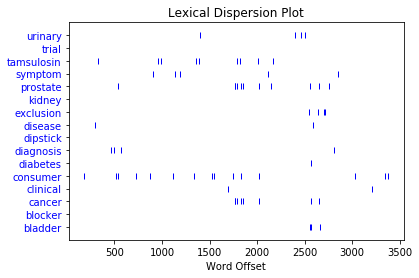

Week2_Q3.txt


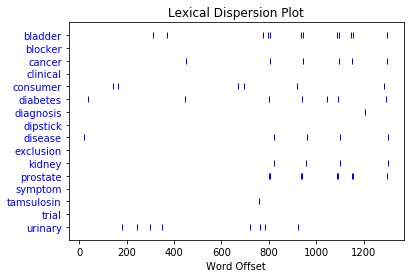

In [116]:
important_words = ['blocker','tamsulosin','exclusion','clinical','cancer','prostate','symptom','bladder','consumer','diagnosis','dipstick','trial','urinary','kidney','disease','diabetes']
important_words = sorted(important_words)
for i in prefix:
    print(i)
    dataset[i].dispersion_plot(important_words)

From the analysis of collocation in Table 2, some of the important themes of the documents can be extracted. Week1_Q2 stands out in this regards as the discussion in this week seemed to cover a lager area of topic as seen in the dispersion plot, week1_Q1 appear to relate to the trial of the drug, while week2 Q1 and Q2 was ‘consumer’ orientated.